In [ ]:
import pandas as pd

index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names

df_train = pd.read_csv('data/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
df_valid = pd.read_csv('data/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])

In [ ]:
def add_date(df):
    df["date"] = pd.to_datetime("2023-01-01") + pd.to_timedelta(df["time_cycles"], unit="d")
    df = df.sort_values(["unit_number", "date"])
    return df

df_train = add_date(df_train)
df_valid = add_date(df_valid)

## Trane

In [ ]:
df = df_train

In [ ]:
import trane

entity_col = "unit_number"
time_col = "date"
meta = {
    "unit_number": ("Integer", {"numeric", "index"}),
    "time_cycles": ("Integer", {"numeric"}),
}
for col in [col for col in df.columns if col.startswith("s")]:
    meta[col] = ("Double", {"numeric"})
meta["date"] = ("DateTime", {})

cutoff_strategy = trane.CutoffStrategy(
    entity_col="unit_number",
    window_size=None,
    minimum_data="2023-01-01",
)

In [ ]:
problem_generator = trane.PredictionProblemGenerator(
    df=df,
    table_meta=meta,
    entity_col=entity_col,
    cutoff_strategy=cutoff_strategy,
    time_col=time_col,
)

In [143]:
problems = problem_generator.generate(df, generate_thresholds=True)

  0%|          | 0/15251 [00:00<?, ?it/s]

In [154]:
ex = problems[0].execute(df, num_examples_per_instance=-1, gap="5d")
problems[0]

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| unit_number: 100/100 


For each <unit_number> predict the number of records in next None days

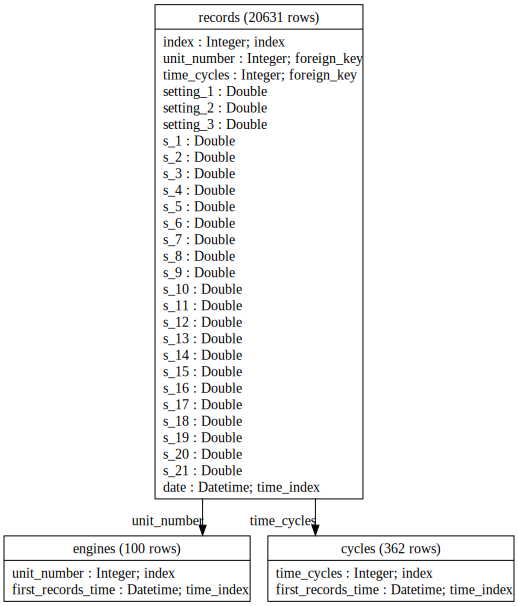

In [177]:
import featuretools as ft
es = ft.EntitySet('observations')

es.add_dataframe(
    dataframe=df.reset_index(),
    dataframe_name='records',
    index='index',
    time_index='date',
)

es.normalize_dataframe(
    base_dataframe_name='records',
    new_dataframe_name='engines',
    index='unit_number',
)

es.normalize_dataframe(
    base_dataframe_name='records',
    new_dataframe_name='cycles',
    index='time_cycles',
)

fm, fd = ft.dfs(
    entityset=es,
    target_dataframe_name='engines',
    cutoff_time=ex,
    agg_primitives=['sum'],
    trans_primitives=[],
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

es.plot()

## ML

In [178]:
fm.reset_index(drop=True, inplace=True)
y = fm.ww.pop('_execute_operations_on_df').astype('category').cat.codes

In [181]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fm, y, test_size=0.2, random_state=0)

In [182]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

LGBMClassifier()

In [183]:
y_hat = model.predict(X_test)

In [184]:
X_test

,SUM(records.s_1),SUM(records.s_10),SUM(records.s_11),SUM(records.s_12),SUM(records.s_13),SUM(records.s_14),SUM(records.s_15),SUM(records.s_16),SUM(records.s_17),SUM(records.s_18),SUM(records.s_19),SUM(records.s_2),SUM(records.s_20),SUM(records.s_21),SUM(records.s_3),SUM(records.s_4),SUM(records.s_5),SUM(records.s_6),SUM(records.s_7),SUM(records.s_8),SUM(records.s_9),SUM(records.setting_1),SUM(records.setting_2),SUM(records.setting_3)
3574,0.00,0.0,0.00,0.00,0.00,0.00,0.0000,0.00,0.0,0.0,0.0,0.00,0.00,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0
1386,9854.73,24.7,899.64,9912.27,45373.06,154615.80,159.8719,0.57,7456.0,45372.0,1900.0,12205.19,739.57,443.8849,30157.55,26672.27,277.78,410.59,10526.53,45373.06,172044.58,0.0121,0.0025,1900.0
499,46161.63,115.7,4230.67,46404.07,212543.09,723278.20,751.1698,2.67,34968.0,212532.0,8900.0,57193.89,3455.65,2073.1044,141515.41,125348.48,1301.18,1923.29,49248.27,212542.94,805170.66,0.0222,0.0026,8900.0
3756,0.00,0.0,0.00,0.00,0.00,0.00,0.0000,0.00,0.0,0.0,0.0,0.00,0.00,0.0000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0000,0.0
914,74688.48,187.2,6862.99,75031.27,343893.92,1170133.00,1217.6301,4.32,56677.0,343872.0,14400.0,92561.87,5580.54,3348.8867,229201.24,203399.80,2105.28,3111.84,79634.26,343894.63,1302651.06,0.0016,0.0022,14400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,38381.58,96.2,3490.54,38652.86,176713.06,602224.90,621.3836,2.22,28962.0,176712.0,7400.0,47512.96,2888.07,1733.2975,117258.99,103422.32,1081.88,1599.03,41034.25,176713.23,670014.44,0.0019,0.0099,7400.0
2510,25414.83,63.7,2325.32,25560.85,117015.78,398734.44,412.9723,1.47,19237.0,117012.0,4900.0,31484.87,1905.65,1143.0862,77778.56,68886.82,716.38,1058.89,27132.12,117016.10,443826.32,0.0241,0.0027,4900.0
4,9854.73,24.7,898.14,9917.71,45372.84,154522.44,159.8259,0.57,7445.0,45372.0,1900.0,12203.32,740.41,444.2810,30152.78,26612.23,277.78,410.59,10527.70,45373.15,171948.79,-0.0120,0.0002,1900.0
682,30601.53,76.7,2785.94,30817.15,140892.26,480510.73,495.6444,1.77,23126.0,140892.0,5900.0,37885.28,2301.75,1381.3051,93507.97,82466.19,862.58,1274.92,32715.24,140892.88,534685.00,-0.0094,0.0051,5900.0


In [188]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_hat)

43.04892601431981